In [163]:
import torch
import torchvision
from torchvision import datasets
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter
from torch import optim
from torchsummary import summary
from PIL import Image
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [164]:
label_strings = {}
with open('human_poses_data/activity_categories.csv', 'r') as fl:
    for i in fl.readlines()[1:]:
        a = i.rstrip().split(';')
        label_strings[int(a[0])] = a[1]

In [165]:
from PIL import Image
import torchvision.transforms

transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    RandomHorizontalFlip(0.5),
    RandomRotation(10),
    RandomVerticalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))
])

train_answers = pd.read_csv('human_poses_data/train_answers.csv', delimiter=';')

X = []
y = []

for index, row in train_answers.iterrows():
    image_id = row[0]
    action = row[1]
    
    image_path = os.path.join('human_poses_data', 'img_train', f'{image_id}.jpg')
    X.append(image_path)
    y.append(action)

C:\Users\Sviat\AppData\Local\Temp\ipykernel_13472\2035404661.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[0]
C:\Users\Sviat\AppData\Local\Temp\ipykernel_13472\2035404661.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  action = row[1]


In [166]:
transforms(Image.open(X[0])).shape

torch.Size([3, 64, 64])

In [167]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return transforms(Image.open(self.images[idx])), self.labels[idx]

dataset = CustomDataset(X, y)

In [168]:
import torch.nn as nn
from torchsummary import summary

class ImprovedVGG(nn.Module):
    def __init__(self, num_classes=20):
        super(ImprovedVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # Adjusted for the output size after feature extraction
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes)  # Output layer for the number of classes
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x


model = ImprovedVGG().to(device)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,248
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,496
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
        MaxPool2d-14           [-1, 64,

In [169]:
from torch.utils.data import random_split

train_set, valid_set = random_split(dataset, (0.95, 0.05))

In [170]:
train_loader = DataLoader(train_set, batch_size=24)
valid_loader = DataLoader(valid_set, batch_size=24)

In [196]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

def train_and_evaluate(model, train_loader, val_loader, num_epochs): 
    train_losses, val_losses = [], [] 
    val_metrics = [] 

    for epoch in range(num_epochs): 
        model.train() 
        train_loss = 0 
        for images, labels in train_loader: 
            images, labels = images.to(device), labels.to(device) 
            optimizer.zero_grad() 
            outputs = model(images) 
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step() 
            train_loss += loss.item() 

        train_loss /= len(train_loader) 
        train_losses.append(train_loss) 
        
        # Validation
        model.eval() 
        val_loss = 0
        all_preds = [] 
        all_labels = [] 
        with torch.no_grad(): 
            for images, labels in val_loader: 
                images, labels = images.to(device), labels.to(device) 
                outputs = model(images)
                loss = criterion(outputs, labels) 
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1) 
                all_preds.extend(preds.cpu().numpy()) 
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(val_loader)
        val_losses.append(val_loss) 
        
        scheduler.step(val_loss)
        acc = accuracy_score(all_labels, all_preds) 
        prec = precision_score(all_labels, all_preds, average="weighted", zero_division=0) 
        rec = recall_score(all_labels, all_preds, average="weighted", zero_division=0) 
        f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0) 
        val_metrics.append((acc, prec, rec, f1)) 
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}") 

train_and_evaluate(model, train_loader, valid_loader, 15)

Epoch 1/15, Train Loss: 1.4065, Val Loss: 1.6824, Val Acc: 0.4822, Val Prec: 0.4938, Val Recall: 0.4822, Val F1: 0.4600
Epoch 2/15, Train Loss: 1.4095, Val Loss: 1.7197, Val Acc: 0.4968, Val Prec: 0.4993, Val Recall: 0.4968, Val F1: 0.4676
Epoch 3/15, Train Loss: 1.4186, Val Loss: 1.6806, Val Acc: 0.5032, Val Prec: 0.5353, Val Recall: 0.5032, Val F1: 0.4773
Epoch 4/15, Train Loss: 1.4156, Val Loss: 1.6704, Val Acc: 0.5032, Val Prec: 0.5260, Val Recall: 0.5032, Val F1: 0.4791
Epoch 5/15, Train Loss: 1.3989, Val Loss: 1.6389, Val Acc: 0.5049, Val Prec: 0.5041, Val Recall: 0.5049, Val F1: 0.4798
Epoch 6/15, Train Loss: 1.3893, Val Loss: 1.5856, Val Acc: 0.5081, Val Prec: 0.5422, Val Recall: 0.5081, Val F1: 0.4940
Epoch 7/15, Train Loss: 1.3583, Val Loss: 1.6979, Val Acc: 0.4773, Val Prec: 0.4929, Val Recall: 0.4773, Val F1: 0.4570


KeyboardInterrupt: 

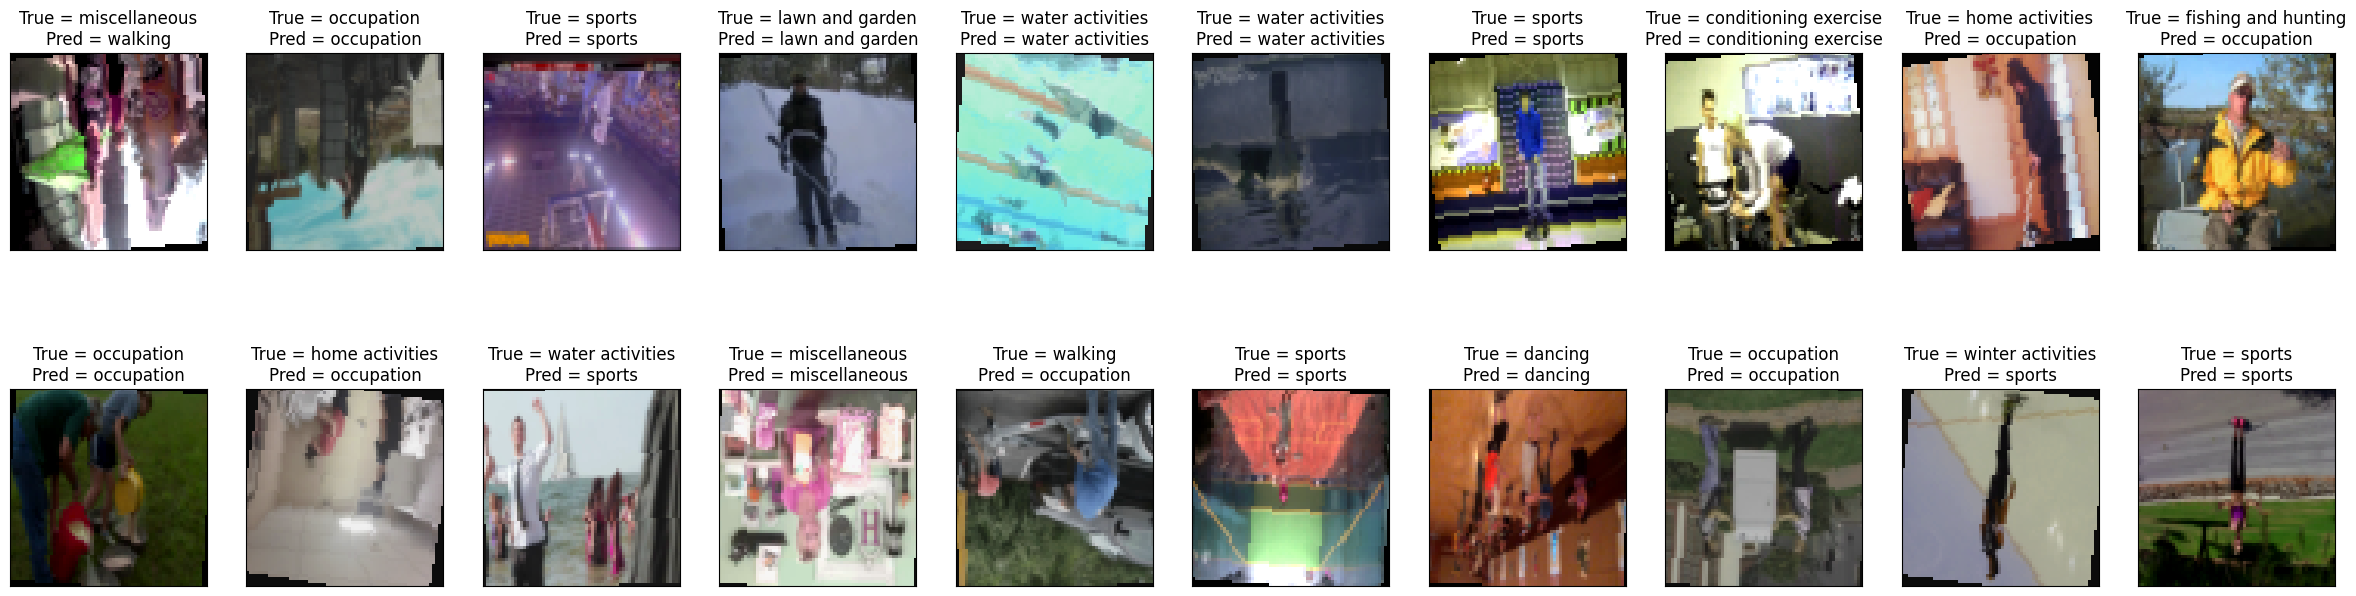

In [197]:
model.eval()

plt.figure(figsize=(30,8))

for i in range(20):
    x, y_true = valid_set[i]
    x = x.to(device).unsqueeze(0)  # Добавляем размер батча
    y_pred = torch.argmax(model(x))
    plt.subplot(2, 10, i + 1)
    plt.imshow(x.cpu().squeeze().permute(1, 2, 0) * 0.25 + 0.5)
    plt.xticks([])
    plt.yticks([])
    plt.title(f'True = {label_strings[y_true]}\nPred = {label_strings[int(y_pred)]}')

plt.show()

In [151]:
# torch.save(model, r'E:\Models\VGGv1.4.pth')
75

In [198]:
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data_frame = os.listdir(root_dir)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.data_frame[idx]))
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame[idx].replace(".jpg", '')


        if self.transform:
            image = self.transform(image)

        return image, int(label)

In [199]:
import os
import csv
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

def get_result(model: torch.nn.Module):
    dataset = CustomTestDataset(r"C:\Users\Sviat\human_poses_data\img_test",
                                    transform=torchvision.transforms.Compose([
                                        torchvision.transforms.Resize((64, 64)),
                                        torchvision.transforms.ToTensor(),
                                        ToDtype(torch.float32, scale=True),
                                        Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25))]))
    dl = DataLoader(dataset, batch_size=128)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    ans = []
    for img, label in tqdm(dl):
        img = img.to(device)
        pred = model.to(device)(img)
        preds = torch.argmax(pred, dim=1)
        res = torch.cat((torch.tensor(label).unsqueeze(1), preds.unsqueeze(1)), dim=1)
        ans.extend(res)
    ans = [[element.item() for element in row] for row in ans]
    with open('result.csv', 'w', newline="") as out_file:
        writer = csv.writer(out_file, delimiter=',')
        writer.writerow(['id', 'target_feature'])
        writer.writerows(ans)

In [200]:
get_result(model)

  0%|                                                                                           | 0/42 [00:00<?, ?it/s]C:\Users\Sviat\AppData\Local\Temp\ipykernel_13472\1657358225.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res = torch.cat((torch.tensor(label).unsqueeze(1), preds.unsqueeze(1)), dim=1)
100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:17<00:00,  1.84s/it]
